# Anomaly Detection

Anomaly detection is the process of identifying unexpected items or events in data sets, which differ from the norm. And anomaly detection is often applied on unlabeled data which is known as unsupervised anomaly detection.

Anomaly detection has two basic assumptions:

* Anomalies only occur very rarely in the data.
* Their features differ from the normal instances significantly

# Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

# Defining Fucntions

In [2]:
def read_dataset(filepath, delimiter=','):
    return genfromtxt(filepath, delimiter=delimiter)

def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000
    epsilons = np.arange(min(probs), max(probs), stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon) 
        f = f1_score(gt, predictions,average='binary')
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
            
    return best_f1, best_epsilon

In [3]:
tr_data = read_dataset('tr_server_data.csv') 
cv_data = read_dataset('cv_server_data.csv') 
gt_data = read_dataset('gt_server_data.csv')

In [4]:
n_training_samples = tr_data.shape[0]
n_dim = tr_data.shape[1]

In [6]:
print('Number of datapoints in training set: %d' % n_training_samples)
print('Number of dimensions/features: %d\n' % n_dim)

print(tr_data[1:5,:])

Number of datapoints in training set: 307
Number of dimensions/features: 2

[[13.409 13.763]
 [14.196 15.853]
 [14.915 16.174]
 [13.577 14.043]]


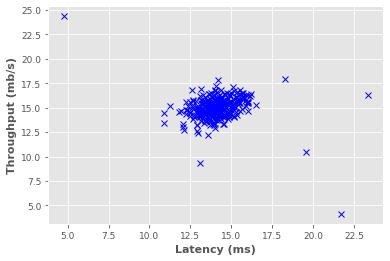

In [9]:
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(tr_data[:,0],tr_data[:,1], 'bx')
plt.show()

# Hyperparameter Tuning

In [10]:
mu, sigma = estimateGaussian(tr_data)
p = multivariateGaussian(tr_data,mu,sigma)

In [11]:
#selecting optimal value of epsilon using cross validation
p_cv = multivariateGaussian(cv_data,mu,sigma)
fscore, ep = selectThresholdByCV(p_cv,gt_data)
print(fscore, ep)

0.8750000000000001 9.036201327981216e-05


In [12]:
outliers = np.asarray(np.where(p < ep))

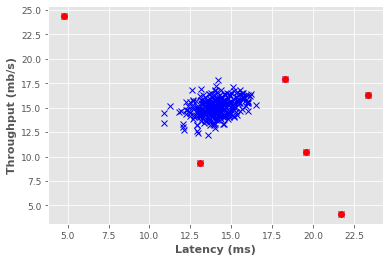

In [13]:
plt.figure()
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(tr_data[:,0],tr_data[:,1],'bx')
plt.plot(tr_data[outliers,0],tr_data[outliers,1],'ro')
plt.show()

# Anomaly Detection Using One-Class SVM

In [14]:
from sklearn import svm

In [15]:
tr_data = read_dataset('tr_server_data.csv')

In [16]:
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
clf.fit(tr_data)

OneClassSVM(gamma=0.1, nu=0.05)

In [18]:
pred = clf.predict(tr_data)

normal = tr_data[pred == 1]
abnormal = tr_data[pred == -1]

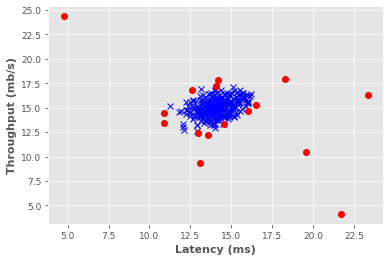

In [19]:
plt.figure()
plt.plot(normal[:,0],normal[:,1],'bx')
plt.plot(abnormal[:,0],abnormal[:,1],'ro')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

# The End!